In [27]:
%matplotlib inline

import quandl as Quandl
Quandl.ApiConfig.api_key = "msKYtye1W9DWW4CuVSnW"
import numpy as np
import pandas as pd
import math
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.ensemble import RandomForestRegressor
import pickle as pkl
from sklearn.svm import SVR, SVC
from functools import reduce
import datetime
style.use('ggplot')

In [19]:
import util as u
from ta import *

In [16]:
tech_tickers = np.array([a.strip().upper() for a in pd.read_csv('companylist.csv')['Symbol']])
quandl_codes_tech_tickers = ["WIKI/"+ticker for ticker in tech_tickers]
tech_data = u.fetch_prices(quandl_codes_tech_tickers, limit=200)

WIKI/VNET does not exist on Quandl's side.
WIKI/JOBS does not exist on Quandl's side.
WIKI/WUBA does not exist on Quandl's side.
WIKI/ACIA does not exist on Quandl's side.
WIKI/ACMR does not exist on Quandl's side.
WIKI/IOTS does not exist on Quandl's side.
WIKI/AER does not exist on Quandl's side.
WIKI/ACY does not exist on Quandl's side.
WIKI/AGMH does not exist on Quandl's side.
WIKI/AIRG does not exist on Quandl's side.
WIKI/AMCN does not exist on Quandl's side.
WIKI/ALRM does not exist on Quandl's side.
WIKI/ALYA does not exist on Quandl's side.
WIKI/ALLT does not exist on Quandl's side.
WIKI/AABA does not exist on Quandl's side.
WIKI/AYX does not exist on Quandl's side.
WIKI/AMRH does not exist on Quandl's side.
WIKI/AMRHW does not exist on Quandl's side.
WIKI/AMN does not exist on Quandl's side.
WIKI/ASYS does not exist on Quandl's side.
WIKI/PLAN does not exist on Quandl's side.
WIKI/APY does not exist on Quandl's side.
WIKI/APPF does not exist on Quandl's side.
WIKI/APPN does 

In [20]:
tech_data = u.apply_to_all_stocks(u.select_relevant_raw_features, tech_data)
tech_data = u.apply_to_all_stocks(u.add_ft_PCT_change, tech_data)
tech_data = u.apply_to_all_stocks(u.select_indicators, tech_data)

/Users/amansidhant/anaconda/lib/python3.6/site-packages/ta/trend.py:170: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
/Users/amansidhant/anaconda/lib/python3.6/site-packages/ta/trend.py:174: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])


In [21]:
sector_idcs = ['NDXX','NDXT','NTTR']
market_idcs = ['NQNA', 'NQUSA', 'NQUSS1500', 'NQUSM450', 'NQUSL300', 'NQUSS', 'NQUSL', 'NQUSM']
sector_idcs, market_idcs = ["NASDAQOMX/"+t for t in sector_idcs], ["NASDAQOMX/"+t for t in market_idcs]




In [22]:
market_urc_idcs = ["URC/"+name for name in ["NASDAQ_ADV", "NASDAQ_UNCH", "NASDAQ_52W_LO", "NASDAQ_52W_HI", "NASDAQ_UNCH_VOL", "NASDAQ_DEC_VOL", "NASDAQ_ADV_VOL", "NASDAQ_UNC", "NASDAQ_DEC"]]

In [23]:
sector_data, market_data = u.fetch_prices(sector_idcs), u.fetch_prices(market_idcs)
market_urc_data = u.fetch_prices(market_urc_idcs)

In [24]:
#drop some columns we don't want
_ = [u.drop_col(df, 'Dividend Market Value') for df in sector_data.values()] #drop div values from all sector data
_ = [u.drop_col(df, 'Dividend Market Value') for df in market_data.values()] #drop div values from all sector data

In [25]:
#featurize
sector_data = u.apply_to_all_stocks(u.add_industry_level_fts, sector_data)
market_data = u.apply_to_all_stocks(u.add_market_level_fts, market_data)
market_data_urc = u.apply_to_all_stocks(u.add_market_urc_level_fts, market_urc_data)

In [28]:
dfs = []
dfs += [df for df in sector_data.values()]
dfs += [df for df in market_data.values()]
dfs += [df for df in market_urc_data.values()]

industry_mkt_fts = reduce(lambda left,right: pd.merge(left,right,how='inner',left_index=True, right_index=True), dfs)

print("Range of industry and market features is in: ", max(industry_mkt_fts.index), min(industry_mkt_fts.index))

Range of industry and market features is in:  2015-08-31 00:00:00 2011-05-16 00:00:00


In [29]:
cleaned_data = {}
cleaned_data_aug = {}

for stock_data,stock_ticker in zip(tech_data.values(), tech_data.keys()):
    

    
    stock_n_market_n_industry = pd.merge(stock_data,
                                          industry_mkt_fts,
                                          how='inner',
                                          left_index=True, 
                                          right_index=True)

    #next, clean and normalize
    try: 
        
        ### MARKET & INDUSTRY
        X,y,X_lately = u.clean_and_split(stock_n_market_n_industry,
                      forecast_pct=0.05,
                      forecast_col='Adj. Close')
    
        cleaned_data_aug[stock_ticker] = (X,y,X_lately)
        
        ### SINGLE STOCK

        stock_data = u.prune_date_range(stock_data, stock_n_market_n_industry)
        X,y,X_lately = u.clean_and_split(stock_data,
                              forecast_pct=0.05,
                              forecast_col='Adj. Close')
        
        cleaned_data[stock_ticker] = (X,y,X_lately)

    except:
        print('skipped one due to NaN/Inf bug!')

/Users/amansidhant/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


skipped one due to NaN/Inf bug!
skipped one due to NaN/Inf bug!


In [30]:
#augmented
with open('cleaned_data_aug.pickle', 'wb') as handle:
    pkl.dump(cleaned_data_aug, handle, protocol=pkl.HIGHEST_PROTOCOL)
    
#individual stock
with open('cleaned_data.pickle', 'wb') as handle:
    pkl.dump(cleaned_data, handle, protocol=pkl.HIGHEST_PROTOCOL)

In [ ]:
def stock_plot(stock_df):
    ''' given stock raw features in df,
        perform two operations:
            1) apply feature generation functions to the df to get the features we need
            2) draw subplots of these features
        
        2) subplot:
            -closing prices
            -PCT change
            -bollinger bands
    '''
    stock_df = u.select_relevant_raw_features(stock_df)
    stock_df = u.add_ft_PCT_change(stock_df)
    stock_df = u.select_indicators(stock_df)
    
    #Closing Price
    stock_df.plot(y='Adj. Close')
    
    #PCT CHANGE
    stock_df.plot(y='HL_PCT')
    stock_df.plot(y='PCT_change')
    
    #Bollinger BandS
    stock_df.plot(y = 'Adj. Close')
#     plt.plot(stock_df['Adj. Close'])
    plt.plot(stock_df['bbandH'], label='High BB')
    plt.plot(stock_df['bbandL'], label='Low BB')
    plt.plot(stock_df['bbandEMA'], label='EMA BB')
    plt.title('Bollinger Bands')
    plt.legend()
    plt.show()
    
    return

In [4]:
def index_plot(index_df):
    ''' given market & industry raw features in df,
        perform two operations:
            1) apply feature generation functions to the df to get the features we need
            2) draw subplots of these features
        
        2) subplot:
            -index value
    '''
    
    #Index Value
    index_df.plot(y='Index Value')
    
    return

/Users/amansidhant/anaconda/lib/python3.6/site-packages/ta/trend.py:170: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
/Users/amansidhant/anaconda/lib/python3.6/site-packages/ta/trend.py:174: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])


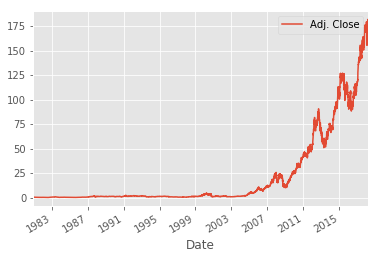

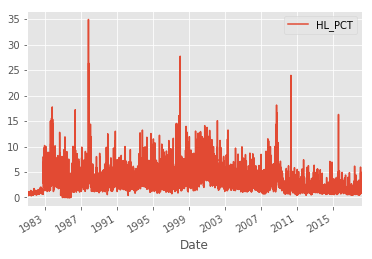

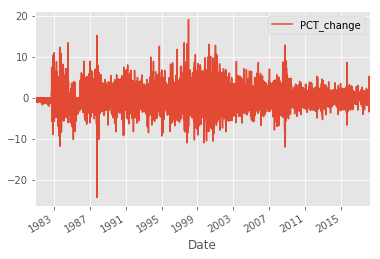

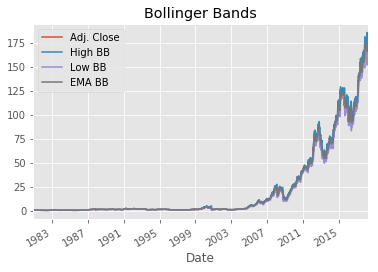

In [5]:
# tech_data['WIKI/TWOU']
ticker = "WIKI/AAPL"
ticker = u.fetch_prices([ticker])[ticker]
ticker = u.select_relevant_raw_features(ticker)

stock_plot(ticker)

/Users/amansidhant/anaconda/lib/python3.6/site-packages/ta/trend.py:170: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
/Users/amansidhant/anaconda/lib/python3.6/site-packages/ta/trend.py:174: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])


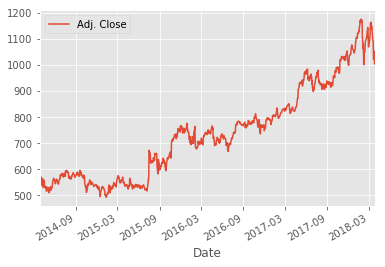

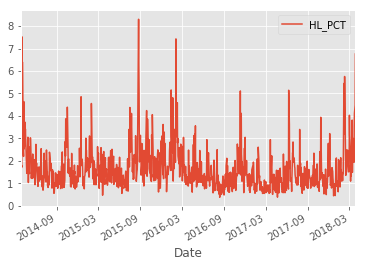

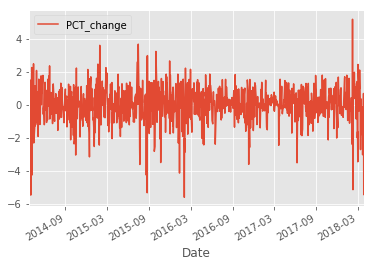

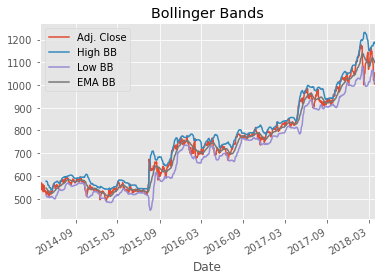

In [6]:
ticker = "WIKI/GOOG"
ticker = u.fetch_prices([ticker])[ticker]
ticker = u.select_relevant_raw_features(ticker)

stock_plot(ticker)

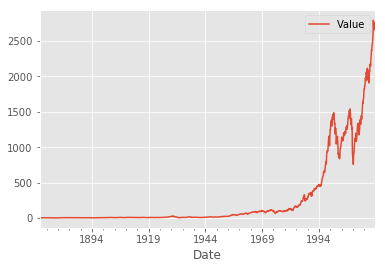

In [7]:
ticker = "MULTPL/SP500_REAL_PRICE_MONTH"
ticker = u.fetch_prices([ticker])[ticker]

ticker.plot(y='Value')

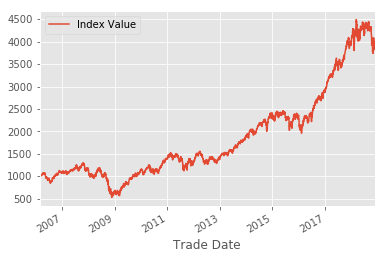

In [8]:
ticker = "NASDAQOMX/NDXT"
ticker = u.fetch_prices([ticker])[ticker]

index_plot(ticker)

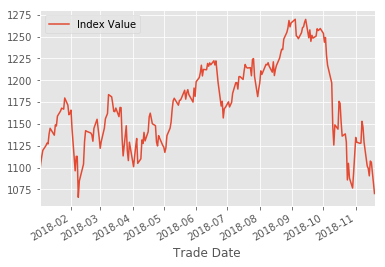

In [9]:
ticker = "NASDAQOMX/NQSUMO"
ticker = u.fetch_prices([ticker])[ticker]

index_plot(ticker)

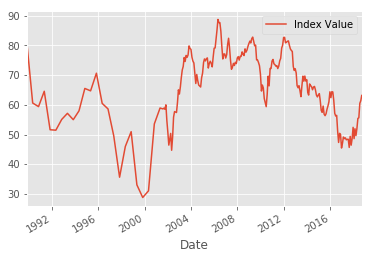

In [10]:
ticker = "YALE/US_CONF_INDEX_VAL_INST"
ticker = u.fetch_prices([ticker])[ticker]

index_plot(ticker)

In [31]:
with open("cleaned_data.pickle", "rb") as input_file:
    cleaned_data = pkl.load(input_file)
    
with open("cleaned_data_aug.pickle", "rb") as input_file:
    cleaned_data_aug = pkl.load(input_file)

print("Number of stocks to predict on: {}".format(len(cleaned_data)))

Number of stocks to predict on: 93


In [40]:
clf_linreg = LinearRegression(n_jobs=-1)
clf_ridge = Ridge()
clf_lasso = Lasso()
clf_elasticnet = ElasticNet()
clf_RF = RandomForestRegressor()
clf_SVR = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)

clfs = [clf_linreg, clf_ridge, clf_lasso,  clf_elasticnet, clf_RF, clf_SVR]

NameError: name 'RandomForestRegressor' is not defined

In [39]:
scores = []
for clf in clfs:
    score = u.average_metrics(cleaned_data, cleaned_data_aug, clf);
    scores += [score]

print(np.array(scores))

TypeError: 'dict_values' object does not support indexing